In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math, random, time
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from scipy.stats import norm
from properscoring import crps_gaussian  

SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

CFG = dict(
    csv_path   = '../data/data.csv',
    target_col  = "load_mw",
    save_name   = "../checkpoints/prob_aedl.pt",  # where to save the model weights

    # ------------- model / trainer settings -------------
    past_len    = 48,  
    pred_len    = 24,     
    batch_size  = 256,
    hidden_size = 128,
    num_layers  = 2,
    attn_heads  = 8,
    dropout     = 0.1,
    lr          = 2e-4,
    epochs      = 50,
    pretrain_ep  = 10, # pre-train epochs (only relevant for probabilistic forecasting)
    es_patience  = 30,
    train_pct   = 0.8,
    val_pct     = 0.2,

    #  exogenous vars
    weather_cols = [
        "temperature",
        "dewpoint",
        "pressure_nn",
        "windspeed",
    ],
    known_future_cols = "temperature_forecast",     

    train_intervals = [("2014-09-02", "2021-12-31 23:00")],
    test_intervals  = [("2022-01-01", "2022-02-28 23:00")],
)

/opt/miniconda3/envs/dhn-predict/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cpu


In [ ]:
# --------------------------- Check environment and PyTorch setup ---------------------------
# This is useful to check if you are running the code in the right environment and with the
# correct PyTorch version, CUDA support, etc. 
import sys, os, torch, numpy as np
print("PY:", sys.version)
print("ENV:", os.environ.get("CONDA_DEFAULT_ENV"))
print("CUDA available:", torch.cuda.is_available())
print("torch:", torch.__version__)
print("cuda:", torch.version.cuda)
print("mps:", torch.backends.mps.is_available() if hasattr(torch.backends, "mps") else None)
print("cudnn:", torch.backends.cudnn.version() if torch.backends.cudnn.is_available() else None)
print("dtype:", torch.get_default_dtype())

# BLAS backend (NumPy/linear algebra speed)
#np.__config__.show()


PY: 3.10.18 | packaged by conda-forge | (main, Jun  4 2025, 14:46:00) [Clang 18.1.8 ]
ENV: dhn-predict
CUDA available: False
torch: 1.13.1
cuda: None
mps: True
cudnn: None
dtype: torch.float32
Build Dependencies:
  blas:
    detection method: pkgconfig
    found: true
    include directory: /opt/arm64-builds/include
    lib directory: /opt/arm64-builds/lib
    name: openblas64
    openblas configuration: USE_64BITINT=1 DYNAMIC_ARCH=1 DYNAMIC_OLDER= NO_CBLAS=
      NO_LAPACK= NO_LAPACKE= NO_AFFINITY=1 USE_OPENMP= SANDYBRIDGE MAX_THREADS=3
    pc file directory: /usr/local/lib/pkgconfig
    version: 0.3.23.dev
  lapack:
    detection method: internal
    found: true
    include directory: unknown
    lib directory: unknown
    name: dep4335948544
    openblas configuration: unknown
    pc file directory: unknown
    version: 1.26.4
Compilers:
  c:
    args: -fno-strict-aliasing, -DBLAS_SYMBOL_SUFFIX=64_, -DHAVE_BLAS_ILP64
    commands: cc
    linker: ld64
    linker args: -fno-strict-ali

In [3]:
# ----------------------- read & tidy data ----------------------------------------------------
raw_df = (
    pd.read_csv(
        CFG["csv_path"],
        sep=",",
        parse_dates=["MESS_DATUM"],   # <— time stamp column
        dayfirst=False,               # flip if your dates are DD-MM-YYYY
        index_col=0
    )
    .rename(columns=str.lower)        # optional: unify lower-case names
)

# give the timestamp an unmistakable name and make it the index
raw_df = raw_df.rename(columns={"mess_datum": "timestamp"}).set_index("timestamp").sort_index()

# cyclic time encodings --------------------------------------------------------
_dt  = raw_df.index
hour = _dt.hour + _dt.minute/60
raw_df["h_sin"], raw_df["h_cos"] = np.sin(2*np.pi*hour/24), np.cos(2*np.pi*hour/24)

dow = _dt.dayofweek
raw_df["dow_sin"], raw_df["dow_cos"] = np.sin(2*np.pi*dow/7), np.cos(2*np.pi*dow/7)

moy = _dt.month - 1
raw_df["moy_sin"], raw_df["moy_cos"] = np.sin(2*np.pi*moy/12), np.cos(2*np.pi*moy/12)

df = raw_df#[[CFG["target_col"], *CFG["weather_cols"],
            #"h_sin", "h_cos", "dow_sin", "dow_cos", "moy_sin", "moy_cos"]].dropna()

In [4]:
# ──────────────────────────  Helpers  ──────────────────────────
def add_time_feats(df: pd.DataFrame) -> pd.DataFrame:
    dt = df.index
    h = dt.hour + dt.minute/60
    df = df.copy()
    df["h_sin"]  = np.sin(2*np.pi*h/24);  df["h_cos"]  = np.cos(2*np.pi*h/24)
    dow = dt.dayofweek
    df["dow_sin"] = np.sin(2*np.pi*dow/7); df["dow_cos"] = np.cos(2*np.pi*dow/7)
    moy = dt.month-1
    df["moy_sin"] = np.sin(2*np.pi*moy/12); df["moy_cos"] = np.cos(2*np.pi*moy/12)
    return df

class SlidingWindowDS(Dataset):
    def __init__(self, df, past, pred, sx, sy, tgt):
        self.X = sx.transform(df.values).astype(np.float32)
        self.y = sy.transform(df[[tgt]].values).astype(np.float32)
        self.p, self.q = past, pred
    def __len__(self): return len(self.X) - (self.p+self.q) + 1
    def __getitem__(self, idx):
        j = idx+self.p
        return (torch.from_numpy(self.X[idx:j]),
                torch.from_numpy(self.y[j:j+self.q]))
        
def loss_fn(mu, logσ, y, α=0.15, λ=2e-3):
    nll  = 0.5*(math.log(2*math.pi)+2*logσ) + (y-mu)**2/(2*torch.exp(2*logσ))
    #  λ·Var bestraft "Aufpumpen"
    penalty = λ * torch.exp(2*logσ).mean()
    mae  = (mu-y).abs().mean()
    return nll.mean() + α*mae + penalty


def evaluate(loader, scaler, mdl, eps=1e-3):
    mdl.eval(); maeS=mapeS=sum_y=nMAE=nMAPE=0
    with torch.no_grad():
        for x,y in loader:
            x=x.to(device); y=y.squeeze(-1)
            mu,_ = mdl(x)
            yK,muK = inverse_scale(y.cpu().numpy(),scaler), inverse_scale(mu.cpu().numpy(),scaler)

            maeS+=np.abs(muK-yK).sum(); nMAE+=yK.size; sum_y+=yK.sum()
            m=np.abs(yK)>eps
            mapeS+=(np.abs(muK-yK)[m]/np.abs(yK[m])).sum(); nMAPE+=m.sum()

    return maeS/nMAE, 100*mapeS/nMAPE, sum_y/nMAE


# ────────────────────────────Plotting & evaluation─────────────────────────────────

def plot_test_trajectories(te_ld, model, sy, device):
    x0, y0 = next(iter(te_ld))
    x0 = x0[:1].to(device)
    y0 = y0[:1].squeeze(-1)                    # (pred_len,)

    with torch.no_grad():
        mu_std, logσ = model(x0)               # Standardraum
    mu_std = mu_std.cpu().numpy()[0]
    σ_std  = np.exp(logσ.cpu().numpy()[0])

    mu_kW = inverse_scale(mu_std, sy)          # μ in kW
    σ_kW  = σ_std * sy.scale_[0]               # σ in kW
    truth = inverse_scale(y0.cpu().numpy(), sy).ravel()

    hrs   = pd.date_range(CFG["test_intervals"][0][0],
                        periods=CFG["pred_len"], freq="H")

    plt.figure(figsize=(10,4))
    plt.fill_between(hrs, mu_kW-1.28*σ_kW, mu_kW+1.28*σ_kW, alpha=0.3, label="±1.28 σ (80 % CI)")
    plt.fill_between(hrs, mu_kW-σ_kW, mu_kW+σ_kW, alpha=0.4, label="±σ (68 % CI)")
    plt.plot(hrs, truth, label="Truth")
    plt.plot(hrs, mu_kW, label="Mean forecast")
    plt.legend(); plt.xticks(rotation=45); plt.tight_layout()
    plt.ylabel("Thermal load [kW]")

    mask = truth != 0
    mape = 100 * (np.abs(mu_kW - truth)[mask] / np.abs(truth[mask])).sum()/ mask.sum()
    mae = np.abs(mu_kW - truth).mean()
    nmae = mae / mu_kW.mean()*100  # normalized MAE

    plt.title(f"MAE  : {mae:,.2f} MW, NMAE  : {nmae:,.2f} %, MAPE : {mape:,.2f} %")
    plt.show()


def gather_predictions(
        model,
        loader,
        device,
        scaler_y,
        head_type="gauss",     # "gauss"  or  "quantile"
        q_index=(0, 1, 2)      # indices of (10 %, 50 %, 90 %) for quantile head
    ):
    """
    Collect μ, σ and y on the ORIGINAL target scale and return them flattened.

    head_type = "gauss"    → model(x) returns (mu , log_sigma)
    head_type = "quantile" → model(x) returns q_std  shape (B, pred_len, K)
                             where q_index gives the (10, 50, 90) % positions.
    """
    mus, sigs, ys = [], [], []
    model.eval()

    # Convenience helpers
    def inv(a):  # inverse‑transform with sklearn-like scaler
        return scaler_y.inverse_transform(a.reshape(-1, 1)).reshape(a.shape)

    k = norm.ppf(0.90)  # used for σ from 10%–90% spread

    with torch.no_grad():
        for batch in loader:
            # Unpack according to your data loader
            if head_type == "gauss":
                (x, y_std) = batch            # simple input/target
                x = x.to(device)

                mu_std, logσ_std = model(x)   # (B, pred_len, 1) or (B, pred_len)
                mu_std   = mu_std.squeeze(-1).cpu().numpy()        # (B, P)
                σ_std    = np.exp(logσ_std.squeeze(-1).cpu().numpy())
                y_std_np = y_std.squeeze(-1).cpu().numpy()         # (B, P)

                # Inverse scale
                mu      = inv(mu_std)                              # (B, P)
                σ       = σ_std * scaler_y.scale_[0]               # same scale factor
                y_true  = inv(y_std_np)                            # (B, P)

            else:  # head_type == "quantile"
                (xb, xc, y_std) = batch        # example 3‑input loader
                xb, xc = xb.to(device), xc.to(device)

                q_std = model(xb, xc).cpu().numpy()  # (B, P, K)
                B, P, K = q_std.shape

                q_orig = inv(q_std.reshape(-1, 1)).reshape(B, P, K)

                # median
                mu      = q_orig[:, :, q_index[1]]                 # (B, P)
                # σ from 10/90 %
                spread  = q_orig[:, :, q_index[2]] - q_orig[:, :, q_index[0]]
                σ       = spread / (2 * k)
                y_true  = inv(y_std.cpu().numpy().reshape(-1, 1)).reshape(B, P)

            # flatten horizon and collect
            mus.append(mu.ravel())
            sigs.append(σ.ravel())
            ys.append(y_true.ravel())

    mus  = np.concatenate(mus)
    sigs = np.concatenate(sigs)
    ys   = np.concatenate(ys)

    return mus, sigs, ys

def inverse_scale(arr: np.ndarray, scaler: StandardScaler):
    return scaler.inverse_transform(arr.reshape(-1,1)).reshape(arr.shape)


In [5]:
# --------------------------- Pribabilistic evaluation metrics ------------------------------------------------
# Gaussian NLL per time step
def gaussian_nll(mu, logσ, y):
    var = torch.exp(2*logσ)
    return 0.5*(math.log(2*math.pi)+2*logσ)+ (y-mu)**2/(2*var)

def test_nll(loader, mdl):
    mdl.eval()
    total_nll = 0.0
    count     = 0
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.squeeze(-1).to(device)
            mu, logσ = mdl(x)
            # gaussian_nll returns per-element loss
            nll = gaussian_nll(mu, logσ, y).cpu().numpy()
            total_nll += nll.sum()
            count     += nll.size
    return total_nll / count

# 95% interval coverage (±1.96σ)
def coverage95(loader, mdl, scaler):
    mdl.eval()
    hits = 0
    tot  = 0
    with torch.no_grad():
        for x, y in loader:
            x_np = x.to(device)
            y_np = y.squeeze(-1).cpu().numpy()
            mu, logσ = mdl(x_np)
            mu_kW    = inverse_scale(mu.cpu().numpy(), scaler)
            σ_kW     = np.exp(logσ.cpu().numpy()) * scaler.scale_[0]
            lo95 = mu_kW - 1.96 * σ_kW
            hi95 = mu_kW + 1.96 * σ_kW
            hits += np.sum((y_np >= lo95) & (y_np <= hi95))
            tot  += y_np.size
    return hits / tot

# Reliability diagram data for quantile levels
def reliability_diagram(mus, sigs, ys, quantiles=None):
    if quantiles is None:
        quantiles = np.linspace(0.05, 0.95, 19)
    obs_freq = []
    for τ in quantiles:
        qτ = mus + sigs * norm.ppf(τ)
        obs_freq.append(np.mean(ys <= qτ))
    return quantiles, np.array(obs_freq)


def brier_reliability(p, o, n_bins=10):
    bins = np.linspace(0, 1, n_bins+1)
    bin_ids = np.digitize(p, bins) - 1
    N = len(p)
    rel_comp = 0.0
    for b in range(n_bins):
        idx = (bin_ids == b)
        if idx.sum() > 0:
            f_bar = p[idx].mean()
            o_bar = o[idx].mean()
            rel_comp += (idx.sum() / N) * (f_bar - o_bar)**2
    return rel_comp


# Reliability diagram data for quantile levels
def reliability_diagram(mus, sigs, ys, quantiles=None):
    if quantiles is None:
        quantiles = np.linspace(0.05, 0.95, 19)
    obs_freq = []
    for τ in quantiles:
        qτ = mus + sigs * norm.ppf(τ)
        obs_freq.append(np.mean(ys <= qτ))
    return quantiles, np.array(obs_freq)

In [6]:
# ----------------------- Data & Loaders ----------------------------------------------------
# Train / Test via Intervall‑Listen
train_df = pd.concat([df.loc[s:e] for s,e in CFG["train_intervals"]])
test_df  = pd.concat([df.loc[s:e] for s,e in CFG["test_intervals"]])
val_df = train_df.iloc[int(len(train_df)*CFG['train_pct']):]     # e.g. last 20 % of train
train_sub = train_df.iloc[:int(len(train_df)*CFG['train_pct'])]   # first 80 %

# Kontext für erstes Testfenster
ctx = CFG["past_len"]
test_ctx = df.loc[train_df.index[-ctx]:test_df.index[-1]]

# Scaler
sx = StandardScaler().fit(train_df.values)
sy = StandardScaler().fit(train_df[[CFG["target_col"]]].values)

# Datasets
tr_ds = SlidingWindowDS(train_df, CFG["past_len"], CFG["pred_len"], sx, sy, CFG["target_col"])
va_ds = SlidingWindowDS(val_df,   CFG["past_len"], CFG["pred_len"], sx, sy, CFG["target_col"])
te_ds = SlidingWindowDS(test_ctx, CFG["past_len"], CFG["pred_len"], sx, sy, CFG["target_col"])
te_ds.indices = range(ctx, len(test_ctx)-CFG["pred_len"]+1)

tr_ld = DataLoader(tr_ds, batch_size=CFG["batch_size"], shuffle=True)
va_ld = DataLoader(va_ds, batch_size=CFG["batch_size"])
te_ld = DataLoader(te_ds, batch_size=CFG["batch_size"])

tgt_idx = df.columns.get_loc(CFG["target_col"])

# FIX
test_w_ctx = df.loc[
    train_df.index[-CFG["past_len"]] : test_df.index[-1]
]

# Standardise on *train only*  ⚠️ never leak test data
scaler_x = StandardScaler().fit(train_df.values)
scaler_y = StandardScaler().fit(train_df[[CFG["target_col"]]].values)

# Training set ------------------------------------------------------
tr_ds = SlidingWindowDS(train_df, CFG["past_len"], CFG["pred_len"],
                        scaler_x, scaler_y, CFG["target_col"])
tr_ld = DataLoader(tr_ds, batch_size=CFG["batch_size"], shuffle=True)

# Validation (optional): split the *training* period further or skip
# --------------------------------------------------------------

# Test set with rolling windows every 1 h ---------------------------
test_ds = SlidingWindowDS(test_w_ctx, CFG["past_len"], CFG["pred_len"],
                        scaler_x, scaler_y, CFG["target_col"])

# BUT we only want windows whose prediction horizon *ends*
# inside the true test period:
idx_end_cutoff = len(test_w_ctx) - CFG["pred_len"]   # last usable start idx
first_test_idx = CFG["past_len"]                           # first usable start idx
test_ds.indices = range(first_test_idx, idx_end_cutoff+1)  # inject a mask
test_ld = DataLoader(test_ds, batch_size=CFG["batch_size"])

va_ds = SlidingWindowDS(val_df,   CFG["past_len"], CFG["pred_len"],
                        scaler_x, scaler_y, CFG["target_col"])
va_ld = DataLoader(va_ds, batch_size=CFG["batch_size"])


In [7]:
# ─────────────────────────────  MODEL  ──────────────────────────────
class AEDLProb(nn.Module):
    def __init__(self, n_feat, hidden, layers, heads, drop, pred_len, tgt_idx):
        super().__init__()
        self.pred_len, self.tgt_idx = pred_len, tgt_idx
        self.enc = nn.LSTM(n_feat, hidden, layers, batch_first=True, dropout=drop)
        self.att = nn.MultiheadAttention(hidden, heads, batch_first=True, dropout=drop)
        self.norm= nn.LayerNorm(hidden)
        self.dec = nn.LSTM(1, hidden, layers, batch_first=True, dropout=drop)
        self.mu_head    = nn.Linear(hidden, 1)
        self.raw_sigma  = nn.Linear(hidden, 1)
        self.softplus   = nn.Softplus()

        # 🌱  kleine Start‑Varianz (~0.1 std‑space)
        nn.init.constant_(self.raw_sigma.weight, 0.)
        nn.init.constant_(self.raw_sigma.bias, math.log(0.1))

    def forward(self, x, *, y_teacher=None):
        seq, (h, c) = self.enc(x)             # h,c: (L,B,H)  (hier L = num_layers)

        # Self‑Attention‑Context in **bestehendes** h[-1] schreiben
        seq_ctx = self.norm(seq + self.att(seq, seq, seq)[0])
        h = h.clone(); c = c.clone()          # Größen unverändert (L,B,H)
        h[-1] = seq_ctx[:, -1]                # nur oberste Layer ersetzen

        dec_in = x[:, -1:, self.tgt_idx:self.tgt_idx+1]
        mus, sigmas = [], []
        for t in range(self.pred_len):
            out, (h, c) = self.dec(dec_in, (h, c))  # Shape jetzt korrekt
            mu    = self.mu_head(out)
            sigma = self.softplus(self.raw_sigma(out)) + 1e-4
            mus.append(mu); sigmas.append(sigma)
            dec_in = y_teacher[:, t:t+1].unsqueeze(-1) if (self.training and
                      y_teacher is not None) else mu

        mu   = torch.cat(mus,   1).squeeze(-1)
        logσ = torch.log(torch.cat(sigmas, 1).squeeze(-1))
        return mu, logσ

# ───────── Modell + Optimizer + Scheduler ─────────
tgt_idx = df.columns.get_loc(CFG["target_col"])
model   = AEDLProb(len(df.columns), CFG["hidden_size"], CFG["num_layers"],
                   CFG["attn_heads"], CFG["dropout"], CFG["pred_len"],
                   tgt_idx).to(device)

mu_params    = [p for n,p in model.named_parameters() if "raw_sigma" not in n]
sigma_params = [p for n,p in model.named_parameters() if "raw_sigma" in  n]

opt = torch.optim.AdamW([
        {"params": mu_params},
        {"params": sigma_params, "lr": CFG["lr"] * 0.1}
      ], lr=CFG["lr"])

sched = torch.optim.lr_scheduler.CosineAnnealingLR(
            opt,
            T_max   = CFG["epochs"] - CFG["pretrain_ep"],
            eta_min = CFG["lr"] * 0.3)

# ------------- Loss ----------------------------------------------
def dual_loss(mu, logσ, y, α=0.15, λ=2e-3):
    var  = torch.exp(2*logσ)
    nll  = 0.5*(math.log(2*math.pi)+2*logσ) + (y-mu)**2/(2*var)
    mae  = (mu - y).abs()
    return nll.mean() + α*mae.mean() + λ*var.mean()


In [ ]:
# --------------------------- Training Loop --------------------------------------
best_val, wait, patience, min_delta = float("inf"), 0, CFG["es_patience"], 0.1
clip_mu, clip_sigma = 1.0, 0.1

print("→ Training …"); total_t = time.time()
for ep in range(1, CFG["epochs"] + 1):
    ep_t = time.time(); model.train()
    use_mae = ep <= CFG["pretrain_ep"]

    for x, y in tr_ld:
        x = x.to(device)
        y = y.squeeze(-1).to(device)          # (B, pred_len)

        mu, logσ = model(x, y_teacher=y if use_mae else None)

        if use_mae:                           # Warm‑up
            loss = (mu - y).abs().mean()
        else:                                 # Dual‑Loss
            loss = dual_loss(mu, logσ, y)

        opt.zero_grad(); loss.backward()
        torch.nn.utils.clip_grad_norm_(mu_params,    clip_mu)
        torch.nn.utils.clip_grad_norm_(sigma_params, clip_sigma)
        opt.step()

    if not use_mae:
        sched.step()                          # Scheduler erst in NLL‑Phase

    # -------- Validation & Early‑Stopping -------------------------
    val_mae, _, _ = evaluate(va_ld, sy, model)
    if best_val - val_mae > min_delta:
        best_val, wait = val_mae, 0
        torch.save(model.state_dict(), CFG["save_name"])
    else:
        wait += 1
        if wait >= patience:
            print(f"⏹ Early stop at epoch {ep}")
            break

    print(f"Ep {ep:02d} | val MAE {val_mae:,.2f} kW | wait {wait}/{patience} | "
          f"⏱ {(time.time()-ep_t):.1f}s")

    print(f"Training time: {(time.time()-total_t)/60:.2f} min")


→ Training …
Ep01 | val MAE 3.11 kW | wait 0/30 | ⏱ 78.2s
Training time: 1.30 min
Ep02 | val MAE 3.01 kW | wait 1/30 | ⏱ 98.5s
Training time: 2.95 min


TEST MAE 13.70 MW | NMAE 51.04% | MAPE 9.13%


/var/folders/2f/70bdv72s5tx7tbn3b58m5xfw0000gn/T/ipykernel_81440/2902481782.py:18: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hrs   = pd.date_range(CFG["test_intervals"][0][0],


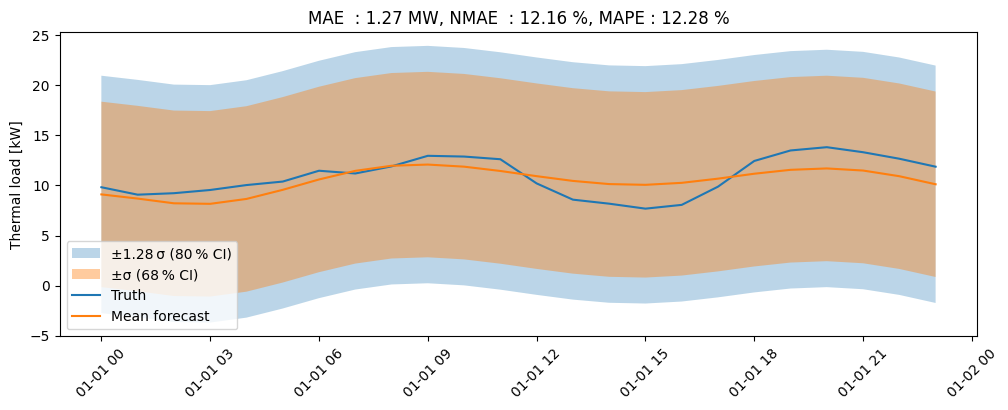

In [ ]:
# --- ----------------------- Test & Plotting -----------------------------------
# 1) Load best checkpoint
model.load_state_dict(torch.load(CFG["save_name"]))
model.eval()

# 2) MAE, MAPE 
mae, mape, mean = evaluate(te_ld, sy, model)
print(f'TEST MAE {mae:.2f} MW | NMAE {mae/mean*100:.2f}% | MAPE {mape:.2f}%')

# 3) Plot example forecast
plot_test_trajectories(te_ld, model, sy, device)

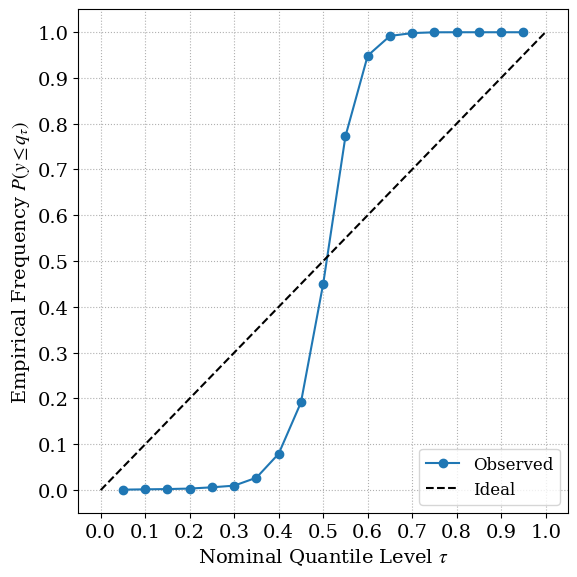

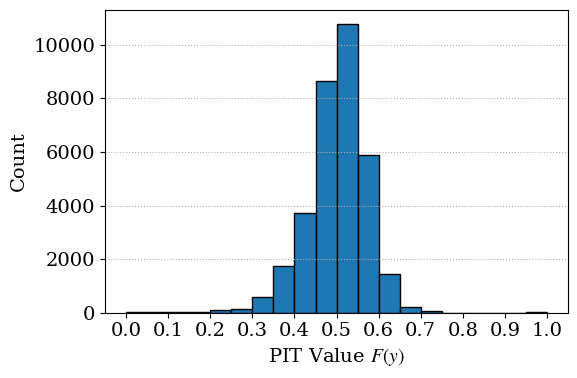

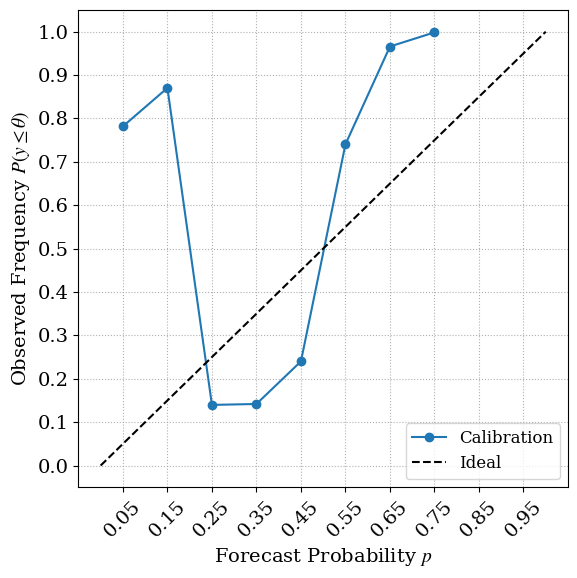

In [ ]:
# --------------------------------- Probabilistic evaluation preparation & plots ---------------------------------

# Gaussian output head
mus, sigs, ys = gather_predictions(model, te_ld, device, scaler_y, head_type="gauss")

# Assume these arrays are already computed:
# taus: 1D array of nominal quantile levels (e.g., np.linspace(0.05, 0.95, 19))
# obs_freq: 1D array of empirical frequencies corresponding to taus
# pit_vals: 1D array of PIT values (F_i(y_i))
# p_event: 1D array of forecasted probabilities for the event {y ≤ θ}
# o_event: 1D array of binary indicators (1 if y ≤ θ, else 0)
# rel_comp: scalar Brier‐Score reliability component

# Matplotlib settings for LaTeX‐style math
plt.rcParams.update({
    "mathtext.fontset": "stix",
    "font.family": "serif",
    "font.size": 14,
})

# Reliability diagram data for quantile levels
taus, obs_freq = reliability_diagram(mus, sigs, ys)

# PIT values
pit_vals = norm.cdf((ys - mus) / sigs)

# Brier‐Score reliability component for threshold event
#    e.g. threshold = your choice, here using the median of y
threshold = np.median(ys)
# Forecasted probability of event {y ≤ threshold}
p_event = norm.cdf((threshold - mus) / sigs)
o_event = (ys <= threshold).astype(int)

rel_comp = brier_reliability(p_event, o_event)

# Reliability diagram data for quantile levels
taus, obs_freq = reliability_diagram(mus, sigs, ys)

# PIT values
pit_vals = norm.cdf((ys - mus) / sigs)


# Reliability diagram
fig, ax = plt.subplots(figsize=(6, 6))
ax.plot(taus, obs_freq, 'o-', label='Observed')
ax.plot([0, 1], [0, 1], 'k--', label='Ideal')
ax.set_xlabel(r'Nominal Quantile Level $\tau$')
ax.set_ylabel(r'Empirical Frequency $P(y \leq q_{\tau})$')
ax.set_xticks(np.linspace(0, 1, 11))
ax.set_yticks(np.linspace(0, 1, 11))
ax.grid(True, linestyle=':')
ax.legend(loc='lower right', fontsize=12)
plt.tight_layout()
plt.show()

# PIT histogram
fig, ax = plt.subplots(figsize=(6, 4))
ax.hist(pit_vals, bins=20, range=(0, 1), edgecolor='black')
ax.set_xlabel(r'PIT Value $F(y)$')
ax.set_ylabel('Count')
ax.set_xticks(np.linspace(0, 1, 11))
ax.grid(axis='y', linestyle=':')
plt.tight_layout()
plt.show()

# Brier‐Score reliability curve
n_bins = 10
bins = np.linspace(0, 1, n_bins + 1)
bin_ids = np.digitize(p_event, bins) - 1
bin_centers = 0.5 * (bins[:-1] + bins[1:])
obs_freq_bins = [
    o_event[bin_ids == b].mean() if np.any(bin_ids == b) else np.nan
    for b in range(n_bins)
]

# Plot Brier‐Score reliability curve
fig, ax = plt.subplots(figsize=(6, 6))
ax.plot(bin_centers, obs_freq_bins, 'o-', label='Calibration')
ax.plot([0, 1], [0, 1], 'k--', label='Ideal')
ax.set_xlabel(r'Forecast Probability $p$')
ax.set_ylabel(r'Observed Frequency $P(y \leq \theta)$')
ax.set_xticks(bin_centers)
ax.set_xticklabels([f"{c:.2f}" for c in bin_centers], rotation=45)
ax.set_yticks(np.linspace(0, 1, 11))
ax.grid(True, linestyle=':')
ax.legend(loc='lower right', fontsize=12)
plt.tight_layout()
plt.show()

In [ ]:
# --------------------------------- Probabilistic evaluation KPIs ---------------------------------

# ─────────────────────────────────────────────────────────────
# Assume mus, sigs, ys are already loaded numpy arrays.
# They may be shape (T, H) — we flatten to 1-D:
# ─────────────────────────────────────────────────────────────

mus  = np.asarray(mus).ravel()
sigs = np.asarray(sigs).ravel()
ys   = np.asarray(ys).ravel()

# Sanity checks
if np.any(sigs <= 0):
    raise ValueError("All σ must be > 0.")
if not (mus.shape == sigs.shape == ys.shape):
    raise ValueError("mus, sigs, ys must have the same length")

# 1) PIT mean (ideal = 0.5)
pit_vals = norm.cdf((ys - mus) / sigs)
pit_mean = pit_vals.mean()

# 2) Mean central 50% interval width (sharpness)
alpha = 0.50
z = norm.ppf(1 - alpha/2)        # ≈ 0.6745
# central width = 2·z·σ
mean_width = np.mean(2 * z * sigs)

# 3) Threshold event: median of y
threshold = np.median(ys)
p_event   = norm.cdf((threshold - mus) / sigs)
o_event   = (ys <= threshold).astype(int)

# 4) Expected Calibration Error (ECE)   
def expected_calibration_error(probs, labels, n_bins=10):
    p = np.asarray(probs, float)
    if p.min() < 0 or p.max() > 1:
        raise ValueError(f"Probs must lie in [0,1], got {p.min():.3f}-{p.max():.3f}")
    y = np.asarray(labels, int)
    bins = np.linspace(0, 1, n_bins+1)
    idx  = np.digitize(p, bins, right=True) - 1
    N    = len(p)
    ece  = 0.0
    for b in range(n_bins):
        m = (idx == b)
        if m.any():
            ece += (m.sum()/N) * abs(p[m].mean() - y[m].mean())
    return ece

ece_value = expected_calibration_error(p_event, o_event, n_bins=10)

# 5) Brier‐Score reliability component
def brier_reliability(p, o, n_bins=10):
    bins = np.linspace(0, 1, n_bins+1)
    idx  = np.digitize(p, bins, right=True) - 1
    N    = len(p)
    rel  = 0.0
    for b in range(n_bins):
        m = (idx == b)
        if m.any():
            rel += (m.sum()/N) * (p[m].mean() - o[m].mean())**2
    return rel

rel_comp = brier_reliability(p_event, o_event, n_bins=10)

# 6) Mean CRPS for Gaussian predictive distributions
crps_vals = crps_gaussian(ys, mus, sigs)
mean_crps = crps_vals.mean()


# 7) Test NLL

test_nll_val = test_nll(te_ld, model)
test_cov95 = coverage95(te_ld, model, sy)

# Print summary
print(f"PIT mean (ideal 0.5):                {pit_mean:.3f}")
print(f"Mean central 50% interval width:     {mean_width:.3f}")
print(f"Expected Calibration Error (ECE):    {ece_value:.5f}")
print(f"Brier reliability component:         {rel_comp:.5f}")
print(f"Mean CRPS (Gaussian):                {mean_crps:.3f}")


print(f"TEST NLL       : {test_nll_val:.4f}")
print(f"95% Coverage   : {test_cov95*100:.2f} %")

# ─── Interpretation ───
#
# • PIT mean ≈0.5 indicates your predictive CDFs are on average well‐calibrated.
#   Values <0.5 signal systematic underprediction; >0.5 signal overprediction.
#
# • Sharpness (mean interval width) ≈ X kW shows the average half‐spread of your
#   central 50% intervals. Narrower widths mean more informative (sharp) forecasts,
#   but only if reliability is good.
#
# • CRPS ≈ Y kW balances calibration and sharpness: lower CRPS means the full
#   forecast distribution tracks the observations more closely in an L2 sense.
#
# • The Brier‐Score reliability component ≈ Z (you printed above) isolates the
#   calibration penalty for a chosen threshold event; smaller is better.
#
# • Test NLL
#   This is the negative log likelihood of the Gaussian predictive distributions
#   on the test set, averaged over all time steps.
#   It measures how well the model predicts the test data.
#   Lower values indicate better predictive performance.


PIT mean (ideal 0.5):                0.501
Mean central 50% interval width:     12.506
Expected Calibration Error (ECE):    0.22470
Brier reliability component:         0.05363
Mean CRPS (Gaussian):                14.740
TEST NLL       : 1254.4296
95% Coverage   : 93.57 %
